In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

11490434/11490434 [==============================] - 1s 0us/step


>##### MNIST에 백색 잡음 픽셀과 0픽셀 추가하기

In [6]:
(train_images, train_labels), _ = mnist.load_data()                     ## data_load
train_images = train_images.reshape(-1, 28*28)                          ## N sample x height x width => N sample x (height*width) 차원 변경.
print("원래 image size:", train_images.shape)

## Normalization(정규화 진행)
train_images = train_images.astype("float32") / 255

## 노이즈 추가
train_images_with_noise_channels = np.concatenate([train_images, np.random.random((len(train_images), 28*28))], axis=1)
print("Noise 추가 image size:", train_images_with_noise_channels.shape)

## 0 픽셀 추가하기
train_images_with_zeros_channels = np.concatenate([train_images, np.zeros((len(train_images), 28*28))], axis=1)
print("0픽셀 추가 image size:", train_images_with_zeros_channels.shape)

원래 image size: (60000, 784)
Noise 추가 image size: (60000, 1568)
0픽셀 추가 image size: (60000, 1568)


>##### 백색 잡음과 0을 추가한 MNIST 데이터에서 모델 훈련

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

In [9]:
model = get_model()
history_noise = model.fit(train_images_with_noise_channels, 
                          train_labels,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.2)


model = get_model()
history_zeros = model.fit(train_images_with_zeros_channels,
                          train_labels,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 6s 15ms/step - loss: 0.6148 - accuracy: 0.8135 - val_loss: 0.3467 - val_accuracy: 0.8850
Epoch 2/10
375/375 [==============================] - 5s 14ms/step - loss: 0.2534 - accuracy: 0.9223 - val_loss: 0.2131 - val_accuracy: 0.9358
Epoch 3/10
375/375 [==============================] - 5s 14ms/step - loss: 0.1657 - accuracy: 0.9485 - val_loss: 0.2179 - val_accuracy: 0.9334
Epoch 4/10
375/375 [==============================] - 5s 14ms/step - loss: 0.1184 - accuracy: 0.9626 - val_loss: 0.1288 - val_accuracy: 0.9638
Epoch 5/10
375/375 [==============================] - 6s 15ms/step - loss: 0.0887 - accuracy: 0.9715 - val_loss: 0.1316 - val_accuracy: 0.9613
Epoch 6/10
375/375 [==============================] - 6s 15ms/step - loss: 0.0655 - accuracy: 0.9796 - val_loss: 0.1517 - val_accuracy: 0.9554
Epoch 7/10
375/375 [==============================] - 5s 14ms/step - loss: 0.0487 - accuracy: 0.9842 - val_loss: 0.1245 - val_accuracy: 0.9656

>##### 검증 정확도 비교 그래프

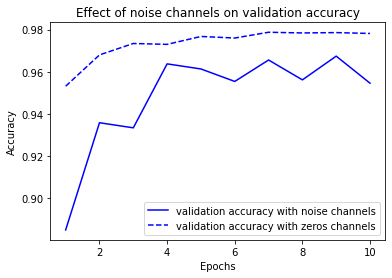

In [10]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]

epochs = range(1, 11)

plt.plot(epochs, val_acc_noise, "b-",
         label="validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="validation accuracy with zeros channels")

plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

> 잡음이 섞인 데이터에서 훈련된 모델의 검증 정확도가 1퍼센트 포인트 정도 낮다.
- 순전히 가짜 상관관계의 영향
- 잡음을 더 많이 섞을수록 정확도는 더 감소

> 잡음 특성은 필연적으로 과대적합(overfitting)을 유발
- 특성이 모델에 유익한지 또는 모델을 혼란스럽게 만드는지 확실하지 않다면 훈련 전에 **특성 선택**을 수행하는 것이 일반적
- 예를 들어 IMDB 데이터에서 가장 자주 등장하는 최상위 1만개 단어로 제한하는 것은 세련되지 않은 특성 선택 방법
- 특성 선택에 일반적인 방법은 가용한 각 특성에 대해 어떤 유용성 점수를 계산(특성과 레이블 사이의 얼마나 유익한지 확인)
- 그 다음에 일정 임계 값을 넘긴 특성만 사용